In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
import scipy.stats as sts
from tqdm import tqdm
from pyts.decomposition import SingularSpectrumAnalysis
from torch.distributions.multivariate_normal import MultivariateNormal

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [200]:
data = pd.read_csv('Data/gen.us.txt')['Close'].values

data = np.log1p(data)

In [61]:
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

In [67]:
def calc_windows_eq_size(data, size=10):
    k = len(data)//size
    windows = []

    for i in range(size):
        windows.append(data[i*k : (i+1)*k])
        
    windows = np.mean(np.array(windows), 1)
    
    return torch.FloatTensor(windows)

# dataloader = DataLoader(windows.reshape(-1, 20, 1), batch_size=20, shuffle=True)

In [68]:
calc_windows_eq_size(data, size=10)

tensor([2.7218, 2.4852, 2.1103, 2.1354, 1.8761, 1.9799, 1.8322, 2.0872, 1.3015,
        1.1722])

In [30]:
groups = [np.arange(i, i + 5) for i in range(0, 20, 4)]
ssa = SingularSpectrumAnalysis(window_size=21, groups=groups)
X_ssa = ssa.fit_transform(data.reshape(1, -1))

In [31]:
X_ssa[0].T

array([[ 2.81884364e+00, -1.15492006e-02, -1.64939036e-02,
         6.94457443e-04,  4.72846156e-05],
       [ 2.82349062e+00,  2.35027847e-03,  2.52071470e-04,
        -1.41927472e-03,  4.54302667e-04],
       [ 2.82346166e+00,  5.18785236e-03,  1.26702567e-02,
        -6.04657773e-04, -1.65255290e-03],
       ...,
       [ 6.60769847e-01, -8.39698243e-03, -1.82213649e-02,
        -9.04651889e-03, -7.70334264e-03],
       [ 6.61385792e-01, -7.07725171e-03,  1.78959327e-03,
         9.06545509e-03,  6.18750339e-03],
       [ 6.63358658e-01,  4.18344145e-03,  1.53945360e-02,
        -4.03668622e-03, -2.76293217e-03]])

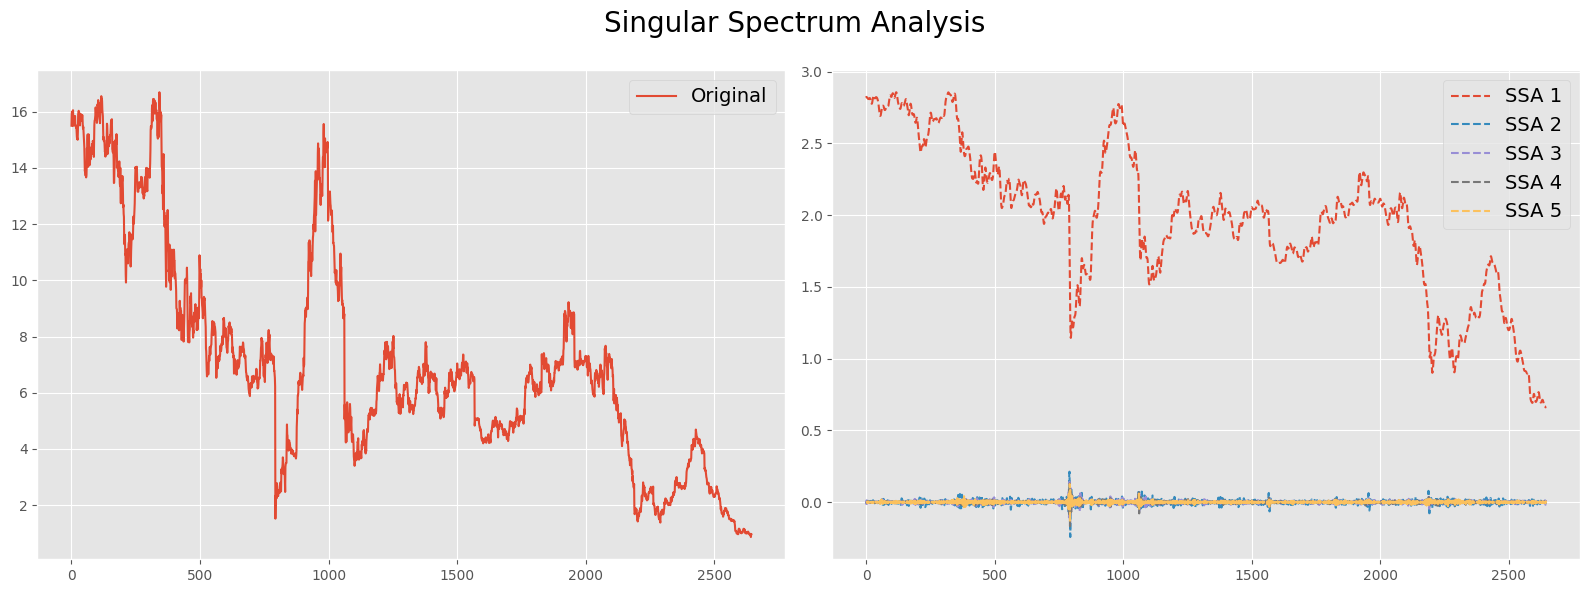

In [54]:
plt.figure(figsize=(16, 6))

ax1 = plt.subplot(121)
ax1.plot(data, label='Original')
ax1.legend(loc='best', fontsize=14)

ax2 = plt.subplot(122)
for i in range(len(groups)):
    ax2.plot(X_ssa[0, i], '--', label='SSA {0}'.format(i + 1))
ax2.legend(loc='best', fontsize=14)

plt.suptitle('Singular Spectrum Analysis', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.88)

plt.show()

In [201]:
def autocorr(x):
    var = x.var()
    mean = x.mean()
    x = x - mean

    result = np.correlate(x, x, mode='full')
    return list(result[len(result)//2:]/var/len(x))

def autocorr_tensor(x, batch_size, seq_len, feature_dim):
    t2 = pd.DataFrame(x.squeeze(2)).apply(lambda x: autocorr(x), axis=1).to_list()
    return torch.FloatTensor(np.array(t2).reshape(batch_size, seq_len, feature_dim))

def spectral_density(x):
    stationarized = pd.Series(x).diff()[1:].diff()[1:].values
    a1 = autocorr(stationarized)
    sd_f = np.fft.fftshift(np.fft.fft(a1))
    # mean_asd = np.mean(np.abs(sd_f)**2)
    
    return np.abs(sd_f)


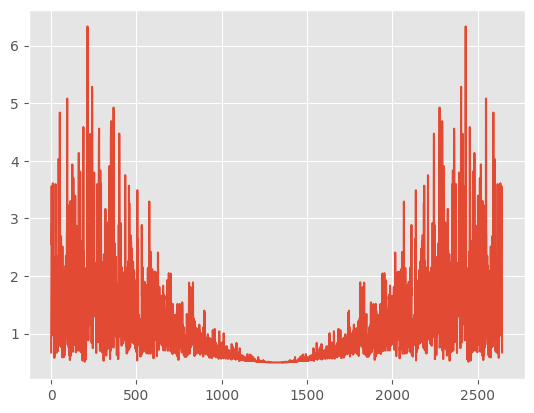

In [202]:
# plt.hist(spectral_density(data), bins=40)
plt.plot(spectral_density(data))

plt.show()

In [203]:
fourier = np.real(np.fft.fftshift(np.fft.fft(data)))
fourier = (fourier - fourier.mean()) / fourier.std()

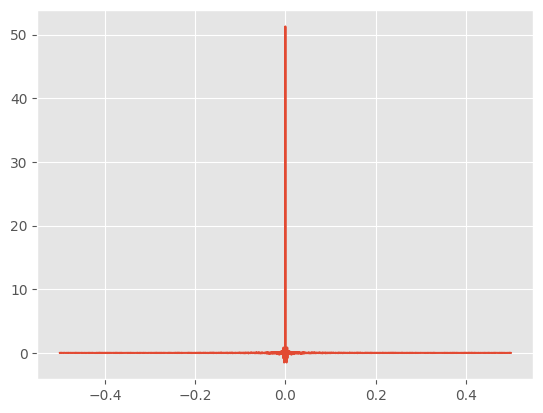

In [204]:
plt.plot(np.fft.fftshift(np.fft.fftfreq(len(data))), fourier)

plt.show()

In [205]:
p_Z = MultivariateNormal(torch.zeros(10), torch.eye(10))
z = p_Z.rsample(sample_shape=(5000,))

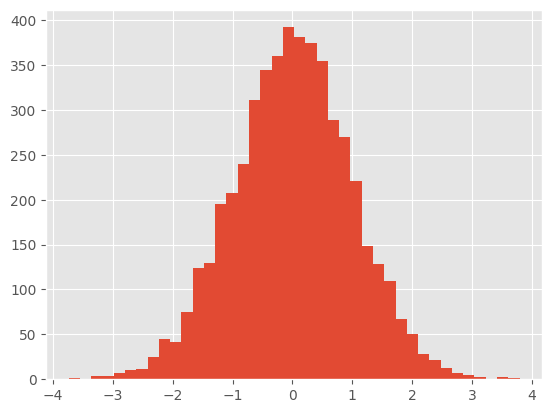

In [206]:
plt.hist(z[:, 0], bins=40)

plt.show()

In [207]:
base_dist = MultivariateNormal(torch.zeros(10), torch.eye(10))

In [208]:
log_pz = base_dist.log_prob(z)

In [211]:
log_pz

tensor([-18.2870, -16.1018, -13.4933,  ..., -12.4548, -17.3331, -13.5215])

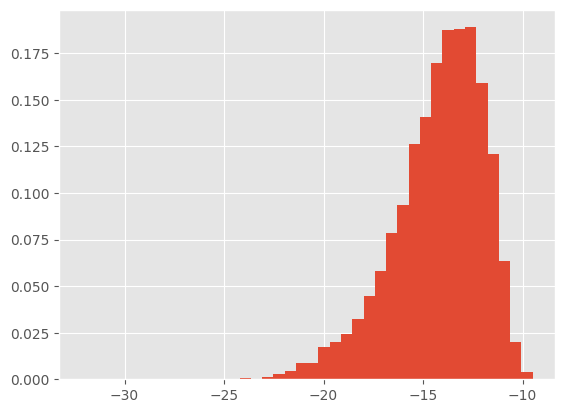

In [210]:
plt.hist(log_pz, bins=40, density=True)

plt.show()